In [1]:
%matplotlib inline  
import os
import pandas as pd
import yfinance as yf
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt
import logging
import pyarrow as pa
import pyarrow.parquet as pq
from scipy import stats
from scipy.signal import savgol_filter
import datetime
logger = logging.getLogger()


For every sector, group stocks together by sector and average the correlation distributions. Also calculate average distribution across all stocks.

For every ticker, compare its distribution of correlations to the global average and to the average of the corresponding sector.

In [202]:
# load data
# parameters
# ============================================================
window_size = 10
ticker = "GME"
start_date = datetime.datetime(day=1, month=1, year=2021)
end_date = datetime.datetime(day=1, month=1, year=2022)
# ============================================================

# read parquet file, convert to dataframe, then select our dates
table = pq.read_table(f'./data/{window_size}/{ticker}.parquet')
df = table.to_pandas()
if start_date is not None:
    df = df[df.index>=start_date]
if end_date is not None:
    df = df[df.index<end_date]

# remove tickers that have null values
na_idx = np.where(df.isna().sum()>0)[0]
tmp = df.isna().sum()
bads = tmp[na_idx]/len(df)>0
for bad_ticker in bads.index[bads==True]:   
    df = df.drop(bad_ticker, axis=1)
    
# create bins for counting correlation of periods
dist = dict()
dist['bins'] = np.arange(-1.0, 1.01, .01)


# load ticker info, get sectors
ticker_info = pd.read_csv('stock_monitor_tickers.csv')
sectors = ticker_info['Sector'].unique()

# get global distribution 
# combine all the correlation scores and get the histogram of it
# use savitzky-golay filter to smooth it out
global_corr = np.reshape(df.to_numpy(), [-1,1])
global_n, _ = np.histogram(global_corr, bins=dist['bins'])
global_n = savgol_filter(global_n, 51, 1)
global_n = global_n/np.sum(global_n)
dist['Global'] = global_n

# get distributions for each sector
ticker_pool = set(df.columns)
for sector in sectors:    
    # get the tickers in this sector
    idx = ticker_info['Sector']==sector
    sector_tickers = set(ticker_info.loc[idx, 'Symbol'])
    # valid tickers are those that are in this sector and that we have data for
    valid_tickers = list(sector_tickers & ticker_pool)
    if ticker in valid_tickers: # don't include yourself in correlations
        valid_tickers.remove(ticker)
    # lump everything together and calculate the histogram, use savgol to smoooth
    sector_corr = np.reshape(df[valid_tickers].to_numpy(), [-1,1])
    sector_n,_ = np.histogram(sector_corr, bins=dist['bins'])
    sector_n = savgol_filter(sector_n, 51, 1)
    sector_n = sector_n/np.sum(sector_n)
    dist[sector] = sector_n

# for every symbol, get is correlation distribution
# smooth it out a little with 1st-order savitzky-golay (moving average)
global_res = pd.DataFrame(columns=['ks','p'], index=df.columns)
sector_res = pd.DataFrame(columns=['ks','p'], index=df.columns)

for symbol in df.columns:            
    n, _ = np.histogram(df[symbol], dist['bins'])
    if sum(n)==0:
        continue           
    n = savgol_filter(n, 51, 1)
    n = n/np.sum(n)
    r = stats.kstest(dist['Global'], n)
    global_res.loc[symbol, 'ks'] = r.statistic
    global_res.loc[symbol, 'p'] = r.pvalue
    
    sector = ticker_info.loc[ticker_info['Symbol']==symbol, 'Sector']
    if len(sector)==0:
        continue
    sector = sector.iloc[0]    
    r = stats.kstest(dist[sector], n)
    sector_res.loc[symbol,'ks'] = r.statistic
    sector_res.loc[symbol,'p'] = r.pvalue
    sector_res.loc[symbol,'sector'] = sector

# save the output
tmp = dist.copy()
tmp['bins'] = tmp['bins'][0:-1]
distributions = pd.DataFrame(tmp)
distributions.index=distributions['bins']
distributions = distributions.drop('bins', axis=1)

start_txt = ""
end_txt = ""
if start_date is not None:
    start_txt = start_date.strftime("%b-%d-%Y")
else:
    start_txt = "Beginning"
if end_date is not None:
    end_txt = end_date.strftime("%b-%d-%Y")
else:
    end_txt = "Present-Day"
tag = f"{window_size}_{start_txt}_{end_txt}"
distributions.to_csv(f'distributions_{tag}.csv')
global_res.to_csv(f'global_scores_{tag}.csv')
sector_res.to_csv(f'sector_scores_{tag}.csv')




In [52]:
window_size = 10
ticker="GME"

table = pq.read_table(f'./data/{window_size}/{ticker}.parquet')
df = table.to_pandas()


start_date = datetime.datetime(day=1, month=1,year=2021)
end_date = datetime.datetime(day=1, month=1, year=2022)

if start_date is not None:
    start_txt = start_date.strftime("%b-%d-%Y")
else:
    start_txt = "Beginning"
if end_date is not None:
    end_txt = end_date.strftime("%b-%d-%Y")
else:
    end_txt = "Present-Day"


global_res = pd.read_csv(f'global_scores_{window_size}_{start_txt}_{end_txt}.csv', index_col=0)
distributions = pd.read_csv(f'distributions_{window_size}_{start_txt}_{end_txt}.csv', index_col='bins')
dist = distributions.to_dict('list')
dist['bins'] = distributions.index.to_numpy()
order = global_res['ks'].sort_values(ascending=False)
out = global_res.loc[order.index]
out = out.drop(ticker)

In [53]:
idx=0
title = "Correlation distributions:"
print(title+" "+start_txt+" to "+end_txt)
while idx<len(out):
    print(f"{idx} of {len(out)}", end='\r' )
    legends = list()
    legends.append("Global")
    figure = plt.figure(figsize=(16,9))
    plt.plot(dist['bins'], dist['Global'],color='black',linewidth=5)

    if idx+5>len(out):
        ticker_list = list(out.index[idx:-1])        
    else:
        ticker_list = list(out.index[idx:idx+5])    

    for i in ticker_list:        
        n,_ = np.histogram(df[i], bins=np.arange(-1,1.01,.01))
        n = n/np.sum(n)
        n = savgol_filter(n, 51, 1)
        plt.plot(dist['bins'], n, linewidth=2)    
        legends.append(f"{i}:ks={out.loc[i,'ks']}, p={out.loc[i,'p']}")

    plt.ylim([-.0025, .02])
    plt.legend(legends,prop={'size': 14})
    

    plt.title(title+" "+start_txt+" to "+end_txt, fontsize=20)
    os.makedirs(f"./plots/global/{window_size}/{start_txt}_{end_txt}/", exist_ok=True)
    plt.savefig(f"./plots/global/{window_size}/{start_txt}_{end_txt}/{idx}_{idx+4}.png", dpi=200, facecolor="white")
    plt.close()
    idx+=5
    print(" "*80, end='\r')
    


Correlation distributions: Jan-01-2021 to Jan-01-2022


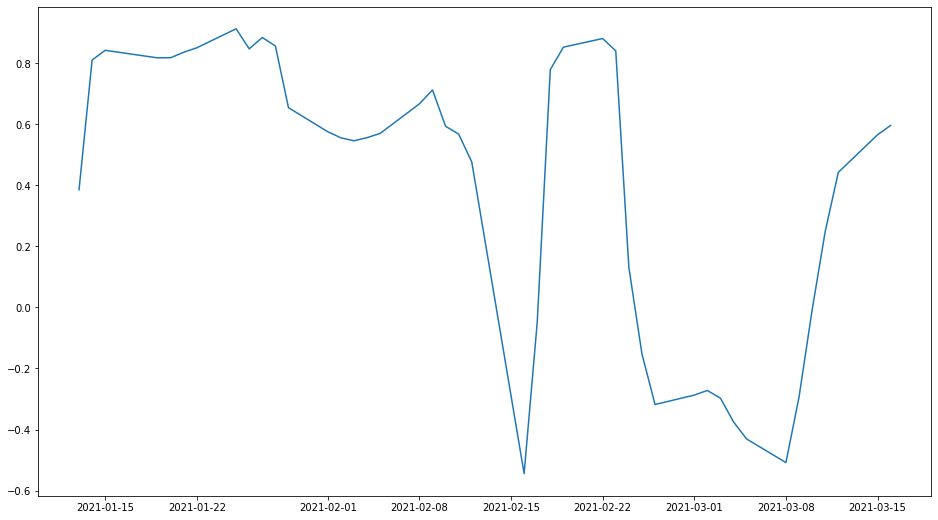

In [151]:
plt.figure(figsize=(16,9))
plt.plot(df['BB'].iloc[7:50])

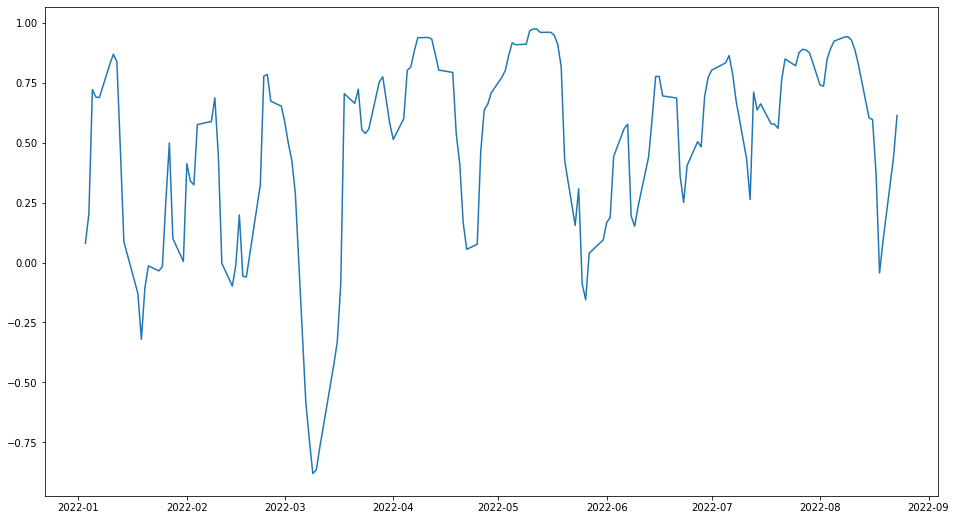

In [14]:
# read parquet file, convert to dataframe, then select our dates
window_size = 10
ticker="GME"
table = pq.read_table(f'./data/{window_size}/{ticker}.parquet')
df = table.to_pandas()
start_date = datetime.datetime(day=1, month=1, year=2022)
stop_date = datetime.datetime(day=1, month=9, year=2022)
idx = np.logical_and(df.index>=start_date, df.index<stop_date)
data = df.loc[idx]

plt.figure(figsize=(16,9))
plt.plot(data['BBBY'])

In [19]:
np.where(out.index=='BB')

(array([77], dtype=int64),)